In [6]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!pip install bs4
from bs4 import BeautifulSoup

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [7]:
url="https://en.wikipedia.org/wiki/List_of_areas_of_London"

In [8]:
html_data  = requests.get(url).text
soup = BeautifulSoup(html_data, 'html5lib')

In [9]:
tag_object=soup.title
print("tag object:",tag_object)

tag object: <title>List of areas of London - Wikipedia</title>


In [10]:
table_contents=[]

table=soup.find("table",{"class":"wikitable sortable"})

#print(table)

# The first tr contains the field names.
headings = [th.get_text().strip() for th in table.find("tr").find_all("th")]

print(headings)

datasets = []
for row in table.find_all("tr")[1:]:
        dataset = dict(zip(headings, (td.get_text() for td in row.find_all("td"))))
        datasets.append(dataset)

#print(datasets 
df = pd.DataFrame(data=datasets)
df = df.replace('\n','', regex=True)
df.columns = ['Neighborhood', 'Borough', 'PostTown', 'PostCode', 'DialCode', 'GridRef']
del df['DialCode']
df['Borough'] = df['Borough'].str.replace(r'\[\d+\]', '')
df = df[["Borough", "Neighborhood", "PostTown", "PostCode", "GridRef"]]
df.head()

['Location', 'London\xa0borough', 'Post town', 'Postcode\xa0district', 'Dial\xa0code', 'OS grid ref']


,Borough,Neighborhood,PostTown,PostCode,GridRef
0,"Bexley, Greenwich",Abbey Wood,LONDON,SE2,TQ465785
1,"Ealing, Hammersmith and Fulham",Acton,LONDON,"W3, W4",TQ205805
2,Croydon,Addington,CROYDON,CR0,TQ375645
3,Croydon,Addiscombe,CROYDON,CR0,TQ345665
4,Bexley,Albany Park,"BEXLEY, SIDCUP","DA5, DA14",TQ478728


In [11]:
df.shape

(531, 5)

In [12]:
import re

geo_contents=[]

for row in table.find_all("tr")[1:]:
        cell = {}
        cols = row.findAll('td')
        if ( cols[5].find('a') is not None):
            cell['grid'] = cols[5].get_text()
            link = cols[5].find('a').get('href')
            m = re.search('.London&params=(.*)_N_', link)
            cell['latitude'] = m.group(1)
            n = re.search('._N_(.*)_[E|W].', link)
            cell['longtitude'] = n.group(1)
            geo_contents.append(cell)
        else:
            pass

# print(table_contents)
df_1=pd.DataFrame(geo_contents)
df_1 = df_1.replace('\n','', regex=True)
df_1.columns = ['GridRef', 'Latitude', 'Longitude']
df_1.head()

,GridRef,Latitude,Longitude
0,TQ465785,51.48648031512,0.10859224316653
1,TQ205805,51.51058775877,0.26498902668911
2,TQ375645,51.362931128458,0.026373738779412
3,TQ345665,51.381621885559,0.068682165650808
4,TQ478728,51.434925966837,0.12492137518833


In [13]:
df_1.shape

(529, 3)

In [16]:
london_geo = pd.merge(df, df_1, on='GridRef')
london_geo = london_geo.drop_duplicates()
del london_geo['PostTown']
del london_geo['PostCode']
del london_geo['GridRef']
london_geo.head()

,Borough,Neighborhood,Latitude,Longitude
0,"Bexley, Greenwich",Abbey Wood,51.48648031512,0.10859224316653
1,"Ealing, Hammersmith and Fulham",Acton,51.51058775877,0.26498902668911
2,Croydon,Addington,51.362931128458,0.026373738779412
3,Croydon,Addiscombe,51.381621885559,0.068682165650808
5,Islington,Angel,51.381621885559,0.068682165650808


In [17]:
london_geo.shape

(529, 4)

In [18]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(london_geo['Borough'].unique()),
        london_geo.shape[0]
    )
)
london_geo["Latitude"] = london_geo["Latitude"].str[:-6]
london_geo["Longitude"] = london_geo["Longitude"].str[:-9]
london_geo["Latitude"] = london_geo["Latitude"].astype(str).astype(float)
london_geo["Longitude"] = london_geo["Longitude"].astype(str).astype(float)
london_geo.head()

The dataframe has 60 boroughs and 529 neighborhoods.


,Borough,Neighborhood,Latitude,Longitude
0,"Bexley, Greenwich",Abbey Wood,51.486480,0.108590
1,"Ealing, Hammersmith and Fulham",Acton,51.510580,0.264980
2,Croydon,Addington,51.362931,0.026373
3,Croydon,Addiscombe,51.381621,0.068682
5,Islington,Angel,51.381621,0.068682


In [19]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[51.5074, -0.1278], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(london_geo['Latitude'], london_geo['Longitude'], london_geo['Borough'], london_geo['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

In [20]:
greenwich_data = london_geo[london_geo["Borough"].str.contains("Greenwich")]
greenwich_data

,Borough,Neighborhood,Latitude,Longitude
0,"Bexley, Greenwich",Abbey Wood,51.486480,0.108590
71,Greenwich,Blackheath Royal Standard,51.459395,0.012333
113,Greenwich,Charlton,51.487752,0.036628
199,Greenwich,Eltham,51.451558,0.049410
206,"Bexley, Greenwich",Falconwood,51.459780,0.092965
232,Greenwich,Greenwich,51.479262,0.007447
299,"Greenwich, Lewisham",Horn Park,51.446591,0.024722
322,Greenwich,Kidbrooke,51.469780,0.035820
365,Greenwich,Maze Hill,51.483582,0.017719
367,Greenwich,Westcombe Park,51.483582,0.017719


In [21]:
# create map of Manhattan using latitude and longitude values
map_greenwich = folium.Map(location=[51.4934, -0.0098], zoom_start=11)

# add markers to map
for lat, lng, label in zip(greenwich_data['Latitude'], greenwich_data['Longitude'], greenwich_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_greenwich)  
    
map_greenwich

In [22]:
#Define Foursquare Credentials and Version
CLIENT_ID = '5KFYURRMF1OAV03RDE4GDEZ0ML22FNO4TAREC3H5TFABGWRI' # your Foursquare ID
CLIENT_SECRET = 'KTU3B21JZFXED4DOXUDKS4033S22MA4MCAIYG3ZUF2B1A3UY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5KFYURRMF1OAV03RDE4GDEZ0ML22FNO4TAREC3H5TFABGWRI
CLIENT_SECRET:KTU3B21JZFXED4DOXUDKS4033S22MA4MCAIYG3ZUF2B1A3UY


In [23]:
greenwich_data.loc[0, 'Neighborhood']

'Abbey Wood'

In [24]:
neighborhood_latitude = greenwich_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = greenwich_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = greenwich_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Abbey Wood are 51.48648, 0.10859.


In [25]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    51.4934, 
    0.0098, 
    radius,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=5KFYURRMF1OAV03RDE4GDEZ0ML22FNO4TAREC3H5TFABGWRI&client_secret=KTU3B21JZFXED4DOXUDKS4033S22MA4MCAIYG3ZUF2B1A3UY&v=20180605&ll=51.4934,0.0098&radius=1000&limit=100'

In [26]:
results = requests.get(url).json()
#results

In [27]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [28]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Greenwich Peninsula Ecology Park,Park,51.495470,0.015590
1,Meantime Brewing Company,Brewery,51.489568,0.008575
2,Greenwich Peninsula Golf Driving Range,Golf Driving Range,51.498099,0.000242
3,Cafe Pura,Café,51.494424,0.013353
4,Up at the O2,Scenic Lookout,51.501376,0.004218


In [29]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

51 venues were returned by Foursquare.


In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
# type your answer here
greenwich_venues = getNearbyVenues(names=greenwich_data['Neighborhood'],
                                   latitudes=greenwich_data['Latitude'],
                                   longitudes=greenwich_data['Longitude']
                                  )

Abbey Wood
Blackheath Royal Standard
Charlton
Eltham
Falconwood
Greenwich
Horn Park
Kidbrooke
Maze Hill
Westcombe Park
Middle Park
New Eltham
Woolwich
Plumstead
Shooter's Hill
Thamesmead
Well Hall


In [32]:
print(greenwich_venues.shape)
greenwich_venues.head()

(147, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.486480,0.108590,Co-op Food,51.487490,0.113751,Grocery Store
1,Abbey Wood,51.486480,0.108590,East Ocean,51.485279,0.102426,Chinese Restaurant
2,Abbey Wood,51.486480,0.108590,Meghna Tandoori,51.485709,0.101681,Indian Restaurant
3,Abbey Wood,51.486480,0.108590,Abbey Cars Cab Office,51.485743,0.101656,Taxi Stand
4,Blackheath Royal Standard,51.459395,0.012333,Carola,51.456741,0.011377,Italian Restaurant


In [33]:
greenwich_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Abbey Wood,4,4,4,4,4,4
Blackheath Royal Standard,13,13,13,13,13,13
Charlton,15,15,15,15,15,15
Eltham,24,24,24,24,24,24
Falconwood,4,4,4,4,4,4
Greenwich,8,8,8,8,8,8
Horn Park,2,2,2,2,2,2
Kidbrooke,4,4,4,4,4,4
Maze Hill,11,11,11,11,11,11


In [34]:
print('There are {} uniques categories.'.format(len(greenwich_venues['Venue Category'].unique())))

There are 66 uniques categories.


In [35]:
# one hot encoding
greenwich_onehot = pd.get_dummies(greenwich_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
greenwich_onehot['Neighborhood'] = greenwich_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [greenwich_onehot.columns[-1]] + list(greenwich_onehot.columns[:-1])
greenwich_onehot = greenwich_onehot[fixed_columns]

greenwich_onehot.head()

,Neighborhood,Asian Restaurant,Bar,Boat or Ferry,Bus Station,Bus Stop,Café,Carpet Store,Castle,Chinese Restaurant,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Department Store,Discount Store,Doner Restaurant,Electronics Store,Fast Food Restaurant,Food Truck,Forest,Fountain,Fried Chicken Joint,Furniture / Home Store,Garden,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Historic Site,Home Service,Hotel,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Lake,Mobile Phone Shop,Movie Theater,Newsagent,Optical Shop,Park,Pharmacy,Pier,Pilates Studio,Pizza Place,Platform,Plaza,Pub,Restaurant,River,Rugby Pitch,Sandwich Place,Scenic Lookout,Shopping Plaza,Soccer Field,Soccer Stadium,Steakhouse,Supermarket,Taxi Stand,Thai Restaurant,Train Station,Tree,Tunnel,Warehouse Store,Zoo Exhibit
0,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Abbey Wood,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Blackheath Royal Standard,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
greenwich_onehot.shape

(147, 67)

In [37]:
greenwich_grouped = greenwich_onehot.groupby('Neighborhood').mean().reset_index()
greenwich_grouped

,Neighborhood,Asian Restaurant,Bar,Boat or Ferry,Bus Station,Bus Stop,Café,Carpet Store,Castle,Chinese Restaurant,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Department Store,Discount Store,Doner Restaurant,Electronics Store,Fast Food Restaurant,Food Truck,Forest,Fountain,Fried Chicken Joint,Furniture / Home Store,Garden,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Historic Site,Home Service,Hotel,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Lake,Mobile Phone Shop,Movie Theater,Newsagent,Optical Shop,Park,Pharmacy,Pier,Pilates Studio,Pizza Place,Platform,Plaza,Pub,Restaurant,River,Rugby Pitch,Sandwich Place,Scenic Lookout,Shopping Plaza,Soccer Field,Soccer Stadium,Steakhouse,Supermarket,Taxi Stand,Thai Restaurant,Train Station,Tree,Tunnel,Warehouse Store,Zoo Exhibit
0,Abbey Wood,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.250000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.250000,0.0,0.00,0.000000,0.00,0.000000,0.250000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.00,0.000000,0.25,0.000000,0.000000,0.000,0.00,0.000000,0.000
1,Blackheath Royal Standard,0.00,0.000000,0.00,0.000000,0.076923,0.153846,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000,0.076923,0.000000,0.000000,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.076923,0.000000,0.076923,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.076923,0.0,0.076923,0.0,0.000000,0.00,0.230769,0.000000,0.00,0.0,0.000000,0.000,0.076923,0.0,0.000000,0.00,0.076923,0.00,0.000000,0.000000,0.000,0.00,0.000000,0.000
2,Charlton,0.00,0.000000,0.00,0.000000,0.066667,0.066667,0.066667,0.00,0.066667,0.000000,0.000000,0.0,0.0,0.000000,0.066667,0.000000,0.066667,0.066667,0.066667,0.00,0.00,0.000000,0.066667,0.000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.066667,0.00,0.066667,0.000000,0.00,0.0,0.000000,0.000,0.000000,0.0,0.066667,0.00,0.066667,0.00,0.066667,0.066667,0.000,0.00,0.000000,0.000
3,Eltham,0.00,0.000000,0.00,0.041667,0.083333,0.041667,0.000000,0.00,0.041667,0.041667,0.041667,0.0,0.0,0.041667,0.000000,0.000000,0.000000,0.125000,0.000000,0.00,0.00,0.000000,0.000000,0.000,0.041667,0.000000,0.000000,0.0,0.00,0.041667,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.041667,0.041667,0.041667,0.000000,0.041667,0.0,0.000000,0.0,0.000000,0.00,0.125000,0.000000,0.00,0.0,0.041667,0.000,0.000000,0.0,0.000000,0.00,0.041667,0.00,0.000000,0.041667,0.000,0.00,0.041667,0.000
4,Falconwood,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.00,0.000000,0.500000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000,0.00,0.000000,0.000
5,Greenwich,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.125,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.250000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.125000,0.000000,0.00,0.0,0.000000,0.125,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.125000,0.125,0.00,0.000000,0.125
6,Horn Park,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0

In [38]:
greenwich_grouped.shape

(17, 67)

In [39]:
num_top_venues = 5

for hood in greenwich_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = greenwich_grouped[greenwich_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abbey Wood----
                venue  freq
0   Indian Restaurant  0.25
1          Taxi Stand  0.25
2  Chinese Restaurant  0.25
3       Grocery Store  0.25
4    Asian Restaurant  0.00


----Blackheath Royal Standard----
                venue  freq
0                 Pub  0.23
1                Café  0.15
2  Italian Restaurant  0.08
3    Kebab Restaurant  0.08
4      Shopping Plaza  0.08


----Charlton----
                    venue  freq
0              Food Truck  0.07
1         Thai Restaurant  0.07
2  Furniture / Home Store  0.07
3                     Pub  0.07
4                Platform  0.07


----Eltham----
                  venue  freq
0                   Pub  0.12
1  Fast Food Restaurant  0.12
2              Bus Stop  0.08
3         Train Station  0.04
4             Gift Shop  0.04


----Falconwood----
                        venue  freq
0           Indian Restaurant   0.5
1  Construction & Landscaping   0.5
2            Asian Restaurant   0.0
3                    Pharmacy   0.0


In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = greenwich_grouped['Neighborhood']

for ind in np.arange(greenwich_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(greenwich_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Indian Restaurant,Chinese Restaurant,Grocery Store,Taxi Stand,Food Truck,Forest,Fountain,Fried Chicken Joint,Furniture / Home Store,Gift Shop
1,Blackheath Royal Standard,Pub,Café,Pharmacy,Italian Restaurant,Bus Stop,Supermarket,Gift Shop,Kebab Restaurant,Pilates Studio,Shopping Plaza
2,Charlton,Electronics Store,Soccer Stadium,Furniture / Home Store,Platform,Chinese Restaurant,Fast Food Restaurant,Carpet Store,Café,Bus Stop,Pub
3,Eltham,Fast Food Restaurant,Pub,Bus Stop,Sandwich Place,Chinese Restaurant,Movie Theater,Pharmacy,Department Store,Coffee Shop,Newsagent
4,Falconwood,Indian Restaurant,Construction & Landscaping,Garden,Food Truck,Forest,Fountain,Fried Chicken Joint,Furniture / Home Store,Gift Shop,Electronics Store


In [42]:
# set number of clusters
kclusters = 5

greenwich_grouped_clustering = greenwich_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(greenwich_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 2, 1, 0, 0, 0, 2, 3], dtype=int32)

In [43]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

greenwich_merged = greenwich_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
greenwich_merged = greenwich_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
greenwich_merged['Cluster Labels'] = greenwich_merged['Cluster Labels'].fillna(0.0)
greenwich_merged['Cluster Labels'] = greenwich_merged['Cluster Labels'].astype(float).astype(int)
greenwich_merged # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bexley, Greenwich",Abbey Wood,51.486480,0.108590,2,Indian Restaurant,Chinese Restaurant,Grocery Store,Taxi Stand,Food Truck,Forest,Fountain,Fried Chicken Joint,Furniture / Home Store,Gift Shop
71,Greenwich,Blackheath Royal Standard,51.459395,0.012333,2,Pub,Café,Pharmacy,Italian Restaurant,Bus Stop,Supermarket,Gift Shop,Kebab Restaurant,Pilates Studio,Shopping Plaza
113,Greenwich,Charlton,51.487752,0.036628,2,Electronics Store,Soccer Stadium,Furniture / Home Store,Platform,Chinese Restaurant,Fast Food Restaurant,Carpet Store,Café,Bus Stop,Pub
199,Greenwich,Eltham,51.451558,0.049410,2,Fast Food Restaurant,Pub,Bus Stop,Sandwich Place,Chinese Restaurant,Movie Theater,Pharmacy,Department Store,Coffee Shop,Newsagent
206,"Bexley, Greenwich",Falconwood,51.459780,0.092965,1,Indian Restaurant,Construction & Landscaping,Garden,Food Truck,Forest,Fountain,Fried Chicken Joint,Furniture / Home Store,Gift Shop,Electronics Store
232,Greenwich,Greenwich,51.479262,0.007447,0,Park,Zoo Exhibit,Scenic Lookout,Garden,Pub,Train Station,Tree,Boat or Ferry,Electronics Store,Gym
299,"Greenwich, Lewisham",Horn Park,51.446591,0.024722,0,Gym / Fitness Center,Park,Zoo Exhibit,Electronics Store,Historic Site,Gym,Grocery Store,Greek Restaurant,Gift Shop,Garden
322,Greenwich,Kidbrooke,51.469780,0.035820,0,Soccer Field,Home Service,Park,Furniture / Home Store,Food Truck,Forest,Fountain,Fried Chicken Joint,Garden,Electronics Store
365,Greenwich,Maze Hill,51.483582,0.017719,2,Bus Stop,Fried Chicken Joint,Hotel,Doner Restaurant,Train Station,Japanese Restaurant,Café,Restaurant,Park,Furniture / Home Store
367,Greenwich,Westcombe Park,51.483582,0.017719,2,Bus Stop,Fried Chicken Joint,Hotel,Doner Restaurant,Train Station,Japanese Restaurant,Café,Restaurant,Park,Furniture / Home Store


In [44]:
# create map
map_clusters = folium.Map(location=[51.4934, -0.0098], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(greenwich_merged['Latitude'], greenwich_merged['Longitude'], greenwich_merged['Neighborhood'], greenwich_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [45]:
greenwich_merged.loc[greenwich_merged['Cluster Labels'] == 0, greenwich_merged.columns[[1] + list(range(5, greenwich_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
232,Greenwich,Park,Zoo Exhibit,Scenic Lookout,Garden,Pub,Train Station,Tree,Boat or Ferry,Electronics Store,Gym
299,Horn Park,Gym / Fitness Center,Park,Zoo Exhibit,Electronics Store,Historic Site,Gym,Grocery Store,Greek Restaurant,Gift Shop,Garden
322,Kidbrooke,Soccer Field,Home Service,Park,Furniture / Home Store,Food Truck,Forest,Fountain,Fried Chicken Joint,Garden,Electronics Store
538,Thamesmead,Soccer Field,Convenience Store,Bus Stop,Lake,Park,Zoo Exhibit,Forest,Fountain,Fried Chicken Joint,Furniture / Home Store


In [46]:
greenwich_merged.loc[greenwich_merged['Cluster Labels'] == 1, greenwich_merged.columns[[1] + list(range(5, greenwich_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
206,Falconwood,Indian Restaurant,Construction & Landscaping,Garden,Food Truck,Forest,Fountain,Fried Chicken Joint,Furniture / Home Store,Gift Shop,Electronics Store


In [47]:
greenwich_merged.loc[greenwich_merged['Cluster Labels'] == 2, greenwich_merged.columns[[1] + list(range(5, greenwich_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Indian Restaurant,Chinese Restaurant,Grocery Store,Taxi Stand,Food Truck,Forest,Fountain,Fried Chicken Joint,Furniture / Home Store,Gift Shop
71,Blackheath Royal Standard,Pub,Café,Pharmacy,Italian Restaurant,Bus Stop,Supermarket,Gift Shop,Kebab Restaurant,Pilates Studio,Shopping Plaza
113,Charlton,Electronics Store,Soccer Stadium,Furniture / Home Store,Platform,Chinese Restaurant,Fast Food Restaurant,Carpet Store,Café,Bus Stop,Pub
199,Eltham,Fast Food Restaurant,Pub,Bus Stop,Sandwich Place,Chinese Restaurant,Movie Theater,Pharmacy,Department Store,Coffee Shop,Newsagent
365,Maze Hill,Bus Stop,Fried Chicken Joint,Hotel,Doner Restaurant,Train Station,Japanese Restaurant,Café,Restaurant,Park,Furniture / Home Store
367,Westcombe Park,Bus Stop,Fried Chicken Joint,Hotel,Doner Restaurant,Train Station,Japanese Restaurant,Café,Restaurant,Park,Furniture / Home Store
387,New Eltham,Indian Restaurant,Bus Stop,Greek Restaurant,Fast Food Restaurant,Grocery Store,Kebab Restaurant,Bar,Gym / Fitness Center,Gym,Historic Site
409,Woolwich,Pier,Clothing Store,Hotel,Italian Restaurant,Warehouse Store,Pharmacy,Mobile Phone Shop,Plaza,Fountain,River
482,Shooter's Hill,Pub,Forest,Café,Castle,Garden,Fast Food Restaurant,Food Truck,Fountain,Fried Chicken Joint,Furniture / Home Store
580,Well Hall,Grocery Store,Pizza Place,Platform,Gym,Bus Station,Bus Stop,Chinese Restaurant,Restaurant,Rugby Pitch,Fountain


In [48]:
greenwich_merged.loc[greenwich_merged['Cluster Labels'] == 3, greenwich_merged.columns[[1] + list(range(5, greenwich_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
370,Middle Park,Italian Restaurant,Electronics Store,Home Service,Historic Site,Gym / Fitness Center,Gym,Grocery Store,Greek Restaurant,Gift Shop,Garden


In [49]:
greenwich_merged.loc[greenwich_merged['Cluster Labels'] == 4, greenwich_merged.columns[[1] + list(range(5, greenwich_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
444,Plumstead,Platform,Train Station,Asian Restaurant,Gym / Fitness Center,Historic Site,Gym,Grocery Store,Greek Restaurant,Electronics Store,Garden


In [50]:
kensington_data = london_geo[london_geo["Borough"].str.contains("Kensington")]
kensington_data

,Borough,Neighborhood,Latitude,Longitude
90,"Kensington and Chelsea, Hammersmith and Fulham",Brompton,51.493842,0.16910
116,Kensington and Chelsea,Chelsea,51.482092,0.16520
178,Kensington and Chelsea,Earls Court,51.490649,0.19516
290,Kensington and Chelsea,Holland Park,51.503408,0.20618
317,Kensington and Chelsea,Kensington,51.500513,0.19330
404,Kensington and Chelsea,North Kensington,51.524232,0.21540
415,Kensington and Chelsea,Notting Hill,51.509721,0.20737
494,Kensington and Chelsea,South Kensington,51.491303,0.17929
584,Kensington and Chelsea,West Brompton,51.486178,0.19677


In [51]:
map_kensington = folium.Map(location=[51.5010, 0.1933], zoom_start=11)

# add markers to map
for lat, lng, label in zip(kensington_data['Latitude'], kensington_data['Longitude'], kensington_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_kensington)  
    
map_kensington

In [52]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius

url_kensington = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    51.5010, 
    0.1933, 
    radius, 
    LIMIT)
url_kensington # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=5KFYURRMF1OAV03RDE4GDEZ0ML22FNO4TAREC3H5TFABGWRI&client_secret=KTU3B21JZFXED4DOXUDKS4033S22MA4MCAIYG3ZUF2B1A3UY&v=20180605&ll=51.501,0.1933&radius=1000&limit=100'

In [53]:
results_kensington = requests.get(url_kensington).json()
#results_kensington

In [54]:
venues_kensington = results_kensington['response']['groups'][0]['items']
    
nearby_venues_kensington = json_normalize(venues_kensington) # flatten JSON

# filter columns
filtered_columns_kensington = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues_kensington =nearby_venues_kensington.loc[:, filtered_columns]

# filter the category for each row
nearby_venues_kensington['venue.categories'] = nearby_venues_kensington.apply(get_category_type, axis=1)

# clean columns
nearby_venues_kensington.columns = [col.split(".")[-1] for col in nearby_venues_kensington.columns]

nearby_venues_kensington

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Concrete Barges,Historic Site,51.498541,0.183252


In [55]:
print('{} venues were returned by Foursquare.'.format(nearby_venues_kensington.shape[0]))

1 venues were returned by Foursquare.


In [56]:
kensington_venues = getNearbyVenues(names=kensington_data['Neighborhood'],
                                   latitudes=kensington_data['Latitude'],
                                   longitudes=kensington_data['Longitude']
                                  )

Brompton
Chelsea
Earls Court
Holland Park
Kensington
North Kensington
Notting Hill
South Kensington
West Brompton


In [57]:
print(kensington_venues.shape)
kensington_venues.head()

(10, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Brompton,51.493842,0.1691,Tarmac Erith Wharf Marine Aggregates,51.495430,0.170810,Construction & Landscaping
1,Chelsea,51.482092,0.1652,Londis,51.484103,0.164667,Convenience Store
2,Chelsea,51.482092,0.1652,Wickes,51.481356,0.169118,Hardware Store
3,Chelsea,51.482092,0.1652,Bus Stop (Alford Road),51.483545,0.161331,Bus Stop
4,Chelsea,51.482092,0.1652,Hayes Engineering,51.483625,0.169947,Automotive Shop


In [58]:
kensington_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Brompton,1,1,1,1,1,1
Chelsea,4,4,4,4,4,4
Earls Court,1,1,1,1,1,1
North Kensington,3,3,3,3,3,3
West Brompton,1,1,1,1,1,1


In [59]:
print('There are {} uniques categories.'.format(len(kensington_venues['Venue Category'].unique())))

There are 9 uniques categories.


In [60]:
# one hot encoding
kensington_onehot = pd.get_dummies(kensington_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kensington_onehot['Neighborhood'] = kensington_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kensington_onehot.columns[-1]] + list(kensington_onehot.columns[:-1])
kensington_onehot = kensington_onehot[fixed_columns]

kensington_onehot.head()

,Neighborhood,Automotive Shop,Bus Stop,Business Service,Construction & Landscaping,Convenience Store,Flower Shop,Hardware Store,Lake,Sandwich Place
0,Brompton,0,0,0,1,0,0,0,0,0
1,Chelsea,0,0,0,0,1,0,0,0,0
2,Chelsea,0,0,0,0,0,0,1,0,0
3,Chelsea,0,1,0,0,0,0,0,0,0
4,Chelsea,1,0,0,0,0,0,0,0,0


In [61]:
kensington_onehot.shape

(10, 10)

In [62]:
kensington_grouped = kensington_onehot.groupby('Neighborhood').mean().reset_index()
kensington_grouped

,Neighborhood,Automotive Shop,Bus Stop,Business Service,Construction & Landscaping,Convenience Store,Flower Shop,Hardware Store,Lake,Sandwich Place
0,Brompton,0.00,0.00,0.0,1.0,0.00,0.000000,0.00,0.000000,0.000000
1,Chelsea,0.25,0.25,0.0,0.0,0.25,0.000000,0.25,0.000000,0.000000
2,Earls Court,0.00,0.00,1.0,0.0,0.00,0.000000,0.00,0.000000,0.000000
3,North Kensington,0.00,0.00,0.0,0.0,0.00,0.333333,0.00,0.333333,0.333333
4,West Brompton,0.00,0.00,1.0,0.0,0.00,0.000000,0.00,0.000000,0.000000


In [63]:
kensington_grouped.shape

(5, 10)

In [64]:
num_top_venues = 5

for hood in kensington_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kensington_grouped[kensington_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Brompton----
                        venue  freq
0  Construction & Landscaping   1.0
1             Automotive Shop   0.0
2                    Bus Stop   0.0
3            Business Service   0.0
4           Convenience Store   0.0


----Chelsea----
               venue  freq
0    Automotive Shop  0.25
1           Bus Stop  0.25
2  Convenience Store  0.25
3     Hardware Store  0.25
4   Business Service  0.00


----Earls Court----
                        venue  freq
0            Business Service   1.0
1             Automotive Shop   0.0
2                    Bus Stop   0.0
3  Construction & Landscaping   0.0
4           Convenience Store   0.0


----North Kensington----
             venue  freq
0      Flower Shop  0.33
1             Lake  0.33
2   Sandwich Place  0.33
3  Automotive Shop  0.00
4         Bus Stop  0.00


----West Brompton----
                        venue  freq
0            Business Service   1.0
1             Automotive Shop   0.0
2                    Bus Stop   0.0
3  C

In [65]:
num_top_venues_kensington = 9

indicators_kensington = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns_kensington = ['Neighborhood']
for ind in np.arange(num_top_venues_kensington):
    try:
        columns_kensington.append('{}{} Most Common Venue'.format(ind+1, indicators_kensington[ind]))
    except:
        columns_kensington.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_kensington = pd.DataFrame(columns=columns_kensington)
neighborhoods_venues_sorted_kensington['Neighborhood'] = kensington_grouped['Neighborhood']

for ind in np.arange(kensington_grouped.shape[0]):
    neighborhoods_venues_sorted_kensington.iloc[ind, 1:] = return_most_common_venues(kensington_grouped.iloc[ind, :], num_top_venues_kensington)

neighborhoods_venues_sorted_kensington.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,Brompton,Construction & Landscaping,Sandwich Place,Lake,Hardware Store,Flower Shop,Convenience Store,Business Service,Bus Stop,Automotive Shop
1,Chelsea,Hardware Store,Convenience Store,Bus Stop,Automotive Shop,Sandwich Place,Lake,Flower Shop,Construction & Landscaping,Business Service
2,Earls Court,Business Service,Sandwich Place,Lake,Hardware Store,Flower Shop,Convenience Store,Construction & Landscaping,Bus Stop,Automotive Shop
3,North Kensington,Sandwich Place,Lake,Flower Shop,Hardware Store,Convenience Store,Construction & Landscaping,Business Service,Bus Stop,Automotive Shop
4,West Brompton,Business Service,Sandwich Place,Lake,Hardware Store,Flower Shop,Convenience Store,Construction & Landscaping,Bus Stop,Automotive Shop


In [66]:
# set number of clusters
kclusters = 5

kensington_grouped_clustering = kensington_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans_kensington = KMeans(n_clusters=kclusters, random_state=0).fit(kensington_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_kensington.labels_[0:10] 

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


array([2, 1, 0, 3, 0], dtype=int32)

In [67]:
# add clustering labels
neighborhoods_venues_sorted_kensington.insert(0, 'Cluster Labels', kmeans_kensington.labels_)

kensington_merged = kensington_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
kensington_merged = kensington_merged.join(neighborhoods_venues_sorted_kensington.set_index('Neighborhood'), on='Neighborhood')
kensington_merged['Cluster Labels'] = kensington_merged['Cluster Labels'].fillna(0.0)
kensington_merged['Cluster Labels'] = kensington_merged['Cluster Labels'].astype(float).astype(int)
kensington_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
90,"Kensington and Chelsea, Hammersmith and Fulham",Brompton,51.493842,0.16910,2,Construction & Landscaping,Sandwich Place,Lake,Hardware Store,Flower Shop,Convenience Store,Business Service,Bus Stop,Automotive Shop
116,Kensington and Chelsea,Chelsea,51.482092,0.16520,1,Hardware Store,Convenience Store,Bus Stop,Automotive Shop,Sandwich Place,Lake,Flower Shop,Construction & Landscaping,Business Service
178,Kensington and Chelsea,Earls Court,51.490649,0.19516,0,Business Service,Sandwich Place,Lake,Hardware Store,Flower Shop,Convenience Store,Construction & Landscaping,Bus Stop,Automotive Shop
290,Kensington and Chelsea,Holland Park,51.503408,0.20618,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
317,Kensington and Chelsea,Kensington,51.500513,0.19330,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# create map
map_clusters_kensington = folium.Map(location=[51.5010, 0.1933], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kensington_merged['Latitude'], kensington_merged['Longitude'], kensington_merged['Neighborhood'], kensington_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_kensington)
       
map_clusters_kensington

In [69]:
kensington_merged.loc[kensington_merged['Cluster Labels'] == 1, kensington_merged.columns[[1] + list(range(5, kensington_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
116,Chelsea,Hardware Store,Convenience Store,Bus Stop,Automotive Shop,Sandwich Place,Lake,Flower Shop,Construction & Landscaping,Business Service


In [70]:
kensington_merged.loc[kensington_merged['Cluster Labels'] == 3, kensington_merged.columns[[1] + list(range(5, kensington_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
404,North Kensington,Sandwich Place,Lake,Flower Shop,Hardware Store,Convenience Store,Construction & Landscaping,Business Service,Bus Stop,Automotive Shop


In [77]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use(['seaborn'])
import matplotlib.pyplot as plot

df_london_res_cnt = pd.read_csv ('City_Of_London_Restaurants_Count.csv')
print(df_london_res_cnt)
df_london_res_cnt.dtypes

              Neighborhood  Count
0           City of London    160
1     Barking and Dagenham     35
2                   Barnet    250
3                   Bexley     95
4                    Brent    195
5                  Bromley    185
6                   Camden    475
7                  Croydon    180
8                   Ealing    185
9                  Enfield    140
10               Greenwich    105
11                 Hackney    265
12  Hammersmith and Fulham    215
13                Haringey    155
14                  Harrow    130
15                Havering    105
16              Hillingdon    110
17                Hounslow    130
18               Islington    310
19  Kensington and Chelsea    290
20    Kingston upon Thames     95
21                 Lambeth    255
22                Lewisham    120
23                  Merton    105
24                  Newham    110
25               Redbridge    125
26    Richmond upon Thames    150
27               Southwark    250
28            

Neighborhood    object
Count            int64
dtype: object

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1800x720 with 0 Axes>

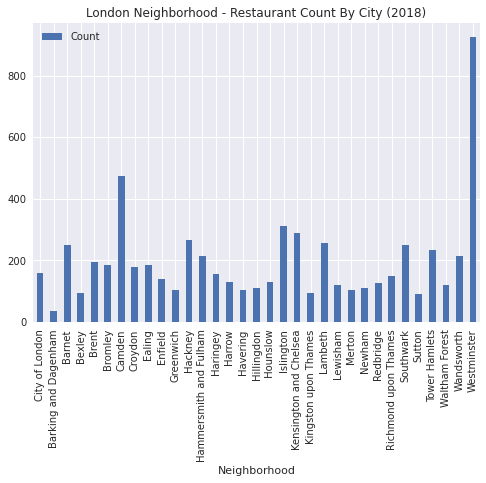

In [86]:
plt.figure(figsize=(25,10))
df_london_res_cnt.plot.bar(x="Neighborhood", y="Count", rot=80, title="London Neighborhood - Restaurant Count By City (2018)");

#plot.show(block=True);
# Increase the width
plt.xticks(rotation=90)
plt.show

In [81]:
df_newyork_res_cnt = pd.read_csv ('City_Of_NewYork_Restaurants_Count.csv')
print(df_newyork_res_cnt)
df_newyork_res_cnt.dtypes

                                 Neighborhood  Count
0                   Jackson Heights/N. Corona    446
1                          Elmhurst/S. Corona    239
2       Washington Heights/Inwood/Marble Hill    345
3             Flushing/Murray Hill/Whitestone    871
4                          Sunnyside/Woodside    514
5                      Bensonhurst/Bath Beach    351
6   Hamilton Heights/Manhattanville/W. Harlem    265
7                 Sunset Park/Windsor Terrace    519
8             Bedford Park/Fordham N./Norwood    151
9                    Astoria/Long Island City    651
10               Hunts Point/Longwood/Melrose    250
11                                   Bushwick    354
12          Briarwood/Fresh Meadows/Hillcrest    251
13       Castle Hill/Clason Point/Parkchester    204
14                    Bay Ridge/Dyker Heights    334
15       Morris Heights/Fordham S./Mount Hope    137
16                  Chinatown/Lower East Side   1251
17                  Jamaica/Hollis/St. Albans 

Neighborhood    object
Count            int64
dtype: object

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2520x1440 with 0 Axes>

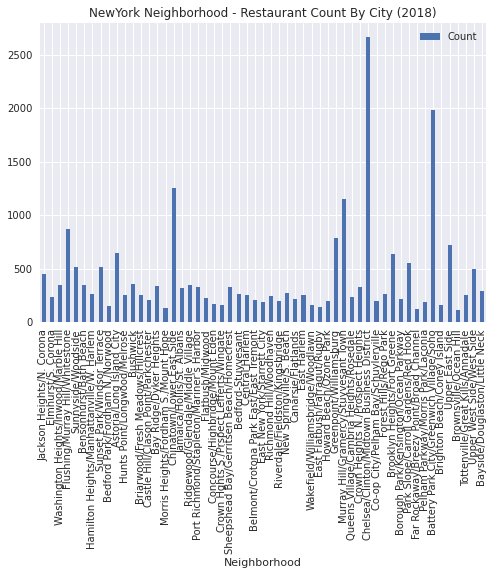

In [85]:
plt.figure(figsize=(35,20))
df_newyork_res_cnt.plot.bar(x="Neighborhood", y="Count", rot=80, title="NewYork Neighborhood - Restaurant Count By City (2018)");

# Increase the width
plt.xticks(rotation=90)
plt.show

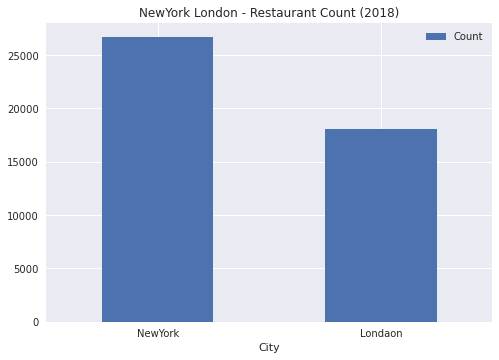

In [84]:
df_total = pd.DataFrame({'City':['NewYork', 'Londaon'], 'Count':[26697, 18110]})
ax = df_total.plot.bar(x='City', y='Count', rot=0, title="NewYork London - Restaurant Count (2018)")